**Implementation of Sentiment Analysis with BERT+CNN in Tensorflow**

 I am going to use a pretreined BERT to compute vector-space representations of a IMDB dataset which has two class
 
 1- **Positive:1**

 2- **Negative:0**
 
This notebook has two section. At the **First part** I will: 

*   Load the IMDB dataset
*   Load a **BERT models** from TensorFlow Hub 
*   Build the model by combining BERT with a classifier
*   Train the model, fine-tuning BERT as part of that
*   Save your model and use it to classify sentences

**Second part** includes using the pretreined BERT to compute vector-space representations of the IMDB dataset to feed to **CNN** downsteam Archtectures.


# **First section**

**About BERT**

BERT (article link [link text](https://arxiv.org/abs/1810.04805)) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.


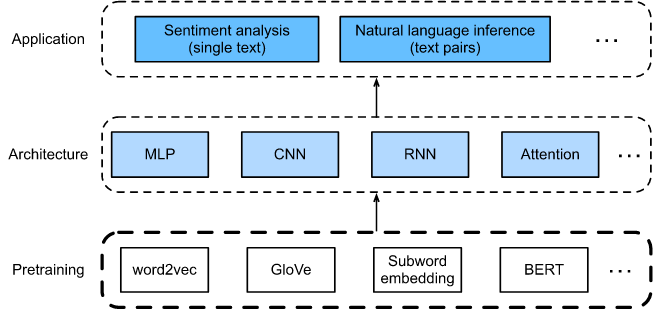



Source: http://www.d2l.ai/chapter_natural-language-processing-pretraining/index.html



**Installing dependencies and importing packages**

In [41]:
!pip install 'tensorflow==2.8.0'

In [42]:
pip install 'tf-estimator-nightly==2.8.0.dev2021122109'

In [43]:
!pip install transformers

In [44]:
# A dependency of the preprocessing for BERT inputs
!pip install tensorflow-text

In [45]:
!pip install tf-models-official==2.7.0

In [46]:
import os
import shutil
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from scipy.stats import spearmanr

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras import layers


from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules


import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks




from tqdm.notebook import tqdm

import math
from math import floor, ceil

from transformers import *


In [47]:
np.set_printoptions(suppress=True)
print(tf.__version__)


2.8.0


**Loading and preparing the dataset**

In [48]:

df = pd.read_csv('/content/IMDBMini Dataset.csv')

In [49]:
nRowsRead = None # specify 'None' if want to read whole file
# labeled_data.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df0 = pd.read_csv('/content/IMDBMini Dataset.csv', delimiter=',', nrows = nRowsRead)
df0.dataframeName = 'IMDB Dataset.csv'
nRow, nCol = df0.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

There are 99 rows and 2 columns


In [50]:
df0.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [51]:
#Doing some adjustments
c=df0['sentiment']
df0.rename(columns={'review' : 'text',
                   'sentiment' : 'category'}, 
                    inplace=True)
a=df0['text']
b=df0['category'].map({'positive': 1, 'negative': 0})

df= pd.concat([a,b,c], axis=1)
df

,text,category,sentiment
0,One of the other reviewers has mentioned that ...,1,positive
1,A wonderful little production. <br /><br />The...,1,positive
2,I thought this was a wonderful way to spend ti...,1,positive
3,Basically there's a family where a little boy ...,0,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,positive
...,...,...,...
94,"I watched this series out of curiosity,wanting...",0,negative
95,Daniel Day-Lewis is the most versatile actor a...,1,positive
96,My guess would be this was originally going to...,0,negative
97,"Well, I like to watch bad horror B-Movies, cau...",0,negative


In [52]:
df.rename(columns={'sentiment' : 'category',
                   'category':'label'}, 
                    inplace=True)
df

,text,label,category
0,One of the other reviewers has mentioned that ...,1,positive
1,A wonderful little production. <br /><br />The...,1,positive
2,I thought this was a wonderful way to spend ti...,1,positive
3,Basically there's a family where a little boy ...,0,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,positive
...,...,...,...
94,"I watched this series out of curiosity,wanting...",0,negative
95,Daniel Day-Lewis is the most versatile actor a...,1,positive
96,My guess would be this was originally going to...,0,negative
97,"Well, I like to watch bad horror B-Movies, cau...",0,negative


In [53]:
# Grouping data by label
df.groupby('label').count()

,text,category
label,,
0,58,58
1,41,41


**Splitting the data between train, validation and test sets:**

In [54]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,    
)

In [55]:
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

In [56]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [57]:
df.groupby(['category', 'label', 'data_type']).count()

text
category label data_type      
negative 0     test          6
               train        47
               val           5
positive 1     test          4
               train        33
               val           4

In [58]:
df

,text,label,category,data_type
0,One of the other reviewers has mentioned that ...,1,positive,train
1,A wonderful little production. <br /><br />The...,1,positive,train
2,I thought this was a wonderful way to spend ti...,1,positive,train
3,Basically there's a family where a little boy ...,0,negative,train
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,positive,train
...,...,...,...,...
94,"I watched this series out of curiosity,wanting...",0,negative,train
95,Daniel Day-Lewis is the most versatile actor a...,1,positive,train
96,My guess would be this was originally going to...,0,negative,train
97,"Well, I like to watch bad horror B-Movies, cau...",0,negative,train


In [59]:
df_train = df.loc[df["data_type"]=="train"]
df_train.head(5)

,text,label,category,data_type
0,One of the other reviewers has mentioned that ...,1,positive,train
1,A wonderful little production. <br /><br />The...,1,positive,train
2,I thought this was a wonderful way to spend ti...,1,positive,train
3,Basically there's a family where a little boy ...,0,negative,train
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,positive,train


In [60]:
df_val = df.loc[df["data_type"]=="val"]
df_val.head(5)

,text,label,category,data_type
10,Phil the Alien is one of those quirky films wh...,0,negative,val
13,The cast played Shakespeare.<br /><br />Shakes...,0,negative,val
18,"I remember this film,it was the first film i h...",1,positive,val
36,The plot is about the death of little children...,0,negative,val
45,"As a disclaimer, I've seen the movie 5-6 times...",1,positive,val


In [61]:
df_test = df.loc[df["data_type"]=="test"]
df_test.head(5)

,text,label,category,data_type
9,If you like original gut wrenching laughter yo...,1,positive,test
14,This a fantastic movie of three prisoners who ...,1,positive,test
15,"Kind of drawn in by the erotic scenes, only to...",0,negative,test
26,"""The Cell"" is an exotic masterpiece, a dizzyin...",1,positive,test
28,This movie was so frustrating. Everything seem...,0,negative,test


In [62]:
df.dtypes

text         object
label         int64
category     object
data_type    object
dtype: object

 **Showing the more frequent words in each class using Wordcloud**

In [63]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

print(type(STOPWORDS))

<class 'set'>


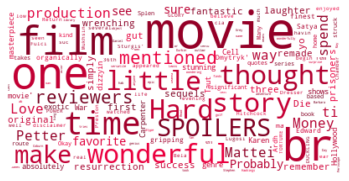

In [64]:


import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(df.loc[df["category"]=="positive"].text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

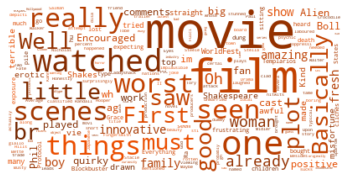

In [65]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 20
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="negative"].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

**Build TensorFlow input**

[Reference ](https://www.tensorflow.org/guide/data)

In [66]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

While **tf.data** tries to propagate shape information, the default settings of Dataset.batch result is an unknown batch size because the last batch may not be full. Note the Nones in the shape


In [67]:
train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Use the drop_remainder argument to ignore that last batch, and get full shape propagation

In [68]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [69]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [70]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

**Loading models from TensorFlow Hub**

This TF Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub at tensorflow/models/official/nlp/bert which L is used as a number of hidden layers and H as hidden size of H, and A as attention heads.


Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

[BERT-Base, Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.

[The Small BERT models](https://tfhub.dev/google/collections/bert/1) are instances of the original BERT architecture with a smaller number L of layers (i.e., residual blocks) combined with a smaller hidden size H and a matching smaller number A of attention heads.

[ALBERT: ](https://tfhub.dev/google/collections/albert/1)four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.

[BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.

[Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose one of the classic BERT sizes or their recent refinements like Electra.

In [71]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'albert_en_base'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',    
  
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/albert_en_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/albert_en_preprocess/3


**The preprocessing model**

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. **TensorFlow Hub** provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

So, the preprocessing model will be loaded into a **hub.KerasLayer** to compose the fine-tuned model. 

In [72]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

**EX)** Let's try the preprocessing model on some text and see the output:

In [73]:
text_test = ['Some films just simply should not be remade']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [    2   109  1491   114  1659   378    52    44 27115     3     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use

**(input_words_id, input_mask and input_type_ids)**

The input is truncated to **128 tokens**. BERT has a constraint on the maximum length of a sequence after tokenizing. For any BERT model, the maximum sequence length after tokenization is 512.

**The input_type_ids** only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

**The input masks** is the mask of the words in a sentence – all masks starts with CLF token and SEP token.So the masked array is of size sentence size + 2. The token is defined for CLF – 101 and SEP – 102 and .Also the input mask is 1 for useful tokens,and 0 for padding. 

**The input_words_ids** has the token ids of the input sequences and gives unique id’s for individual words. Each word is encoded(ids can be from a vocabulary), padded and separated Length.

In [74]:
#text_preprocessed

To generate embedding now all we need to do is to pass this text_preprocessed to the encoder. 

In [75]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [76]:
bert_results = bert_model(text_preprocessed)

In [77]:

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/albert_en_base/2
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.4974522  -0.4022627   0.70687973 -0.5386651  -0.23866722 -0.955195
  0.45889893 -0.4052007   0.5196632  -0.99271435  0.99731493  0.5130328 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.3006409  -0.21103102  0.8600876  ... -0.32910538 -0.6263893
  -0.39718994]
 [-0.40866277 -0.7162431   1.9335173  ...  0.48289305  2.6212182
  -0.38708568]
 [-0.36012593 -0.5044639  -0.06619332 ... -0.8388238   0.74398655
  -0.8650751 ]
 ...
 [ 0.06696129  0.11210939 -0.08660927 ... -0.09616762  0.15163468
   0.20022365]
 [ 0.02630872 -0.10308027  0.08278503 ...  0.2832733   0.7887378
   0.07300374]
 [-0.07706296  0.13267407  0.27017093 ...  0.20253178  0.8113287
  -0.13738221]]


The BERT models return a map with 3 important keys: **pooled_output, sequence_output, encoder_outputs:**

**pooled_output** represents each input sequence as a whole. The shape is **[batch_size, H]**. You can think of this as an embedding for the entire movie review.

**sequence_output** represents each input token in the context. The shape is **[batch_size, seq_length, H**]. You can think of this as a contextual embedding for every token in the movie review.

**encoder_outputs** are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape **[batch_size, seq_length, 1024]** with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.

In [78]:
#bert_results

**Define the model**

The fine-tuned model will be created with the preprocessing model, and the selected BERT model, one Dense and a Dropout layer.

In [79]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [80]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5176603]], shape=(1, 1), dtype=float32)


tf.sigmoid Computes sigmoid of x element-wiseand it measures the probability error in discrete classification tasks in which each class is independent and not mutually exclusive.If a positive number is large, then its sigmoid will approach to 1 since the formula If a negative number is large, its sigmoid will approach to 0. [Reference](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid) 

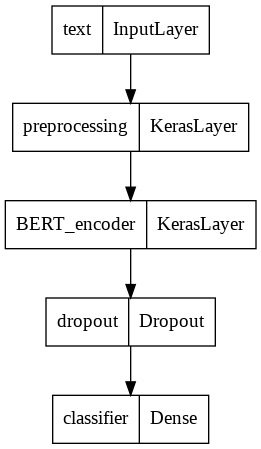

In [81]:
tf.keras.utils.plot_model(classifier_model)

**Model training**

I now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

**Loss function**

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), I'll use losses.BinaryCrossentropy loss function.

In [82]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

**Optimizer**

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.

For the learning rate (init_lr), I will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [83]:
from official.nlp import optimization

In [84]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

**Loading the BERT model and training**

In [85]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [86]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Epoch 1/5
3/3 [==============================] - 16s 1s/step - loss: 0.7737 - binary_accuracy: 0.5625 - val_loss: 0.7775 - val_binary_accuracy: 0.4444
Epoch 2/5
3/3 [==============================] - 3s 851ms/step - loss: 0.6001 - binary_accuracy: 0.6500 - val_loss: 0.7389 - val_binary_accuracy: 0.5556
Epoch 3/5
3/3 [==============================] - 3s 856ms/step - loss: 0.4578 - binary_accuracy: 0.8250 - val_loss: 0.7660 - val_binary_accuracy: 0.4444
Epoch 4/5
3/3 [==============================] - 3s 853ms/step - loss: 0.3289 - binary_accuracy: 0.9500 - val_loss: 0.8000 - val_binary_accuracy: 0.4444
Epoch 5/5
3/3 [==============================] - 3s 858ms/step - loss: 0.3446 - binary_accuracy: 0.9500 - val_loss: 0.8017 - val_binary_accuracy: 0.4444


**Evaluate the model**
Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [87]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 0s 102ms/step - loss: 0.7346 - binary_accuracy: 0.4000
Loss: 0.7345608472824097
Accuracy: 0.4000000059604645


**Plot the accuracy and loss over time**

Based on the History object returned by model.fit() the training and validation loss can be plotted for comparison, as well as the training and validation accuracy.

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


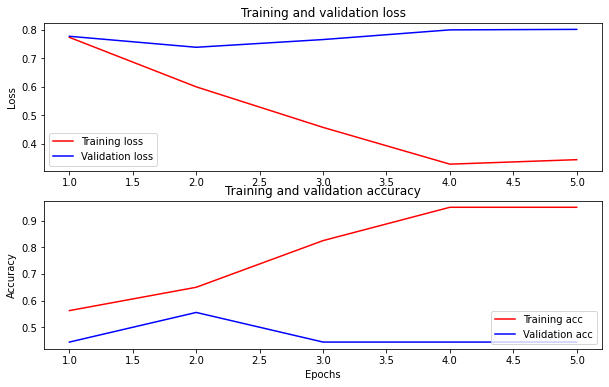

In [88]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

**Export for inference**

Now the fine-tuned model will be saved for later use.

In [89]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./imdb_bert/assets


INFO:tensorflow:Assets written to: ./imdb_bert/assets


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [90]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test the model on any sentence you want, just add to the examples variable below.

In [91]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy..',
    'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it''s not preachy or boring..',
    'Encouraged by the positive comments about this film on here I was looking forward to watching this film..',
    'This a fantastic movie of three prisoners who become famous..',
    'Some films just simply should not be remade..'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy.. : score: 0.449985
input: Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but its not preachy or boring.. : score: 0.599876
input: Encouraged by the positive comments about this film on here I was looking forward to watching this film.. : score: 0.459320
input: This a fantastic movie of three prisoners who become famous.. : score: 0.566083
input: Some films just simply should not be remade.. : score: 0.469990

Results from the model in memory:
input: I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy.. : score: 0.449986
input: Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but its not 

#**Second part**

**BERT + CNN Model**

For the implementation with CNN, I am using the sequence_output as input to the convolutional layer. It represents each input token in the context. **The shape is [batch_size, seq_length, H].** You can think of this as a contextual embedding for every token in the text. This outputs saves positional information about the inputs, then it would male cense to feed a convolutional layer.

In [92]:
def build_CNN_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    #net = outputs['pooled_output'] # [batch_size, 768].
    net = sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 768]
      
    
    net = tf.keras.layers.Conv1D(32, (2), activation='relu')(net)
    #net = tf.keras.layers.MaxPooling1D(2)(net)
    
    net = tf.keras.layers.Conv1D(64, (2), activation='relu')(net)
    #net = tf.keras.layers.MaxPooling1D(2)(net)
    net = tf.keras.layers.GlobalMaxPool1D()(net)
    
#    net = tf.keras.layers.Flatten()(net)
    
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    
    net = tf.keras.layers.Dropout(0.1)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

**ReLU** stands for rectified linear unit, and is a type of activation function. Mathematically, it is defined as y = max(0, x). It is linear (identity) for all positive values, and zero for all negative values.

Also, **tf.keras.layers.Conv1D** creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. [Reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) 

**Tf.keras.layers.GlobalMaxPool1D()** downsamples the input representation by taking the maximum value over the time dimension.[Reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D)


The **Dropout** layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.[Reference ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)


**Dense** implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True). These are all attributes of Dense.[Reference ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [94]:
cnn_classifier_model = build_CNN_classifier_model()
bert_raw_result = cnn_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.53429234 0.63618904 0.5753598 ]], shape=(1, 3), dtype=float32)


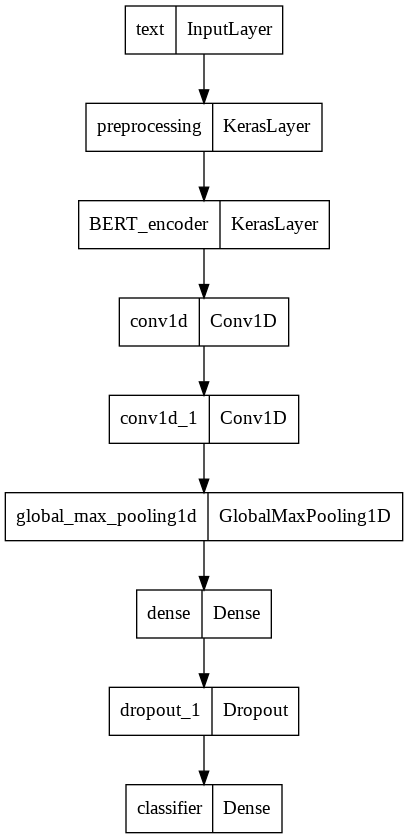

In [95]:
tf.keras.utils.plot_model(cnn_classifier_model)

In [96]:
cnn_classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [97]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#metrics = tf.metrics.CategoricalCrossentropy()
#metrics = tf.metrics.Accuracy()

In [98]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

cnn_classifier_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

Defining the weights for BERT+CNN the model.

In [99]:
#This is an balanced dataset.
positive, negative = np.bincount(df['label'])
total = positive + negative 
print('Examples:\n    Total: {}\n    positive: {} ({:.2f}% of total)\n'.format(
    total, positive, 100 * positive / total))
print('Examples:\n    Total: {}\n    negative: {} ({:.2f}% of total)\n'.format(
    total, negative, 100 * negative / total))


Examples:
    Total: 99
    positive: 58 (58.59% of total)

Examples:
    Total: 99
    negative: 41 (41.41% of total)



In [100]:
weight_for_0 = (1 /positive)*(total)/2.0 
weight_for_1 = (1 / negative)*(total)/2.0



class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.85
Weight for class 1: 1.21


In [101]:

print(f'Training model with {tfhub_handle_encoder}')
cnn_history = cnn_classifier_model.fit(x=train_ds,
                                       validation_data=val_ds,
                                       epochs=epochs,
                                       class_weight=class_weight
                                       
                                      )

Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 27s 2s/step - loss: 1.3005 - accuracy: 0.3375 - val_loss: 1.1664 - val_accuracy: 0.4444
Epoch 2/10
3/3 [==============================] - 3s 859ms/step - loss: 1.0169 - accuracy: 0.4000 - val_loss: 0.9547 - val_accuracy: 0.4444
Epoch 3/10
3/3 [==============================] - 3s 857ms/step - loss: 0.8329 - accuracy: 0.6000 - val_loss: 0.8844 - val_accuracy: 0.5556
Epoch 4/10
3/3 [==============================] - 3s 861ms/step - loss: 0.6548 - accuracy: 0.8375 - val_loss: 0.8442 - val_accuracy: 0.5556
Epoch 5/10
3/3 [==============================] - 3s 860ms/step - loss: 0.5368 - accuracy: 0.8750 - val_loss: 0.8242 - val_accuracy: 0.4444
Epoch 6/10
3/3 [==============================] - 3s 863ms/step - loss: 0.4140 - accuracy: 0.9875 - val_loss: 0.8087 - val_accuracy: 0.4444
Epoch 7/10
3/3 [==============================] - 3s 865ms/step - loss: 0.3693 - accuracy: 0.9875 - val_loss: 0.8031 - val_accuracy: 0.2222
Epoch 8/10
3/3 [=================

In [102]:
loss, accuracy = cnn_classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 0s 285ms/step - loss: 0.7022 - accuracy: 0.6000
Loss: 0.7021920084953308
Accuracy: 0.6000000238418579


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


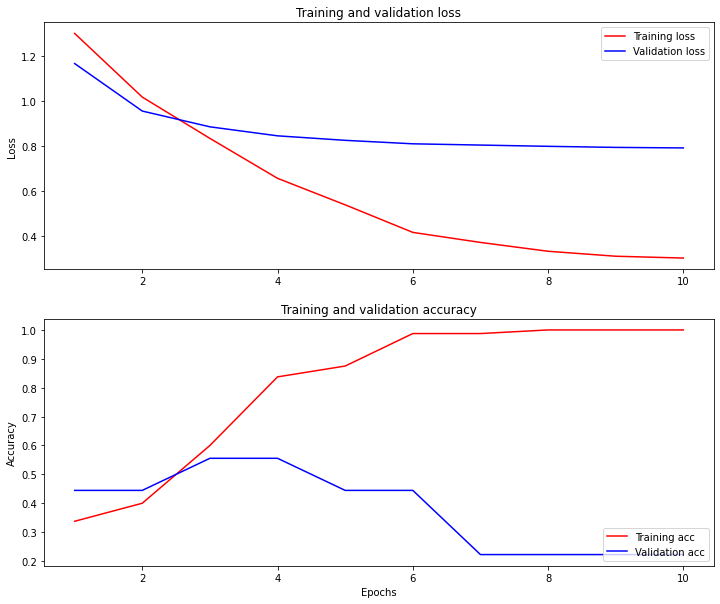

In [103]:
history_dict = cnn_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [104]:
result =  cnn_classifier_model.predict(test_ds)
print(result.shape)

(10, 3)


**Export for inference**
Now you just save your fine-tuned model for later use


In [106]:
dataset_name = 'cnn_hate_speech'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

cnn_classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./cnn_hate_speech_bert/assets


INFO:tensorflow:Assets written to: ./cnn_hate_speech_bert/assets


In [107]:
reloaded_model = tf.saved_model.load(saved_model_path)

**Results for CNN**

In [108]:
result =  cnn_classifier_model.predict(test_ds)
print(result.shape)

(10, 3)


In [105]:
result

array([[0.5513337 , 0.382715  , 0.06595128],
       [0.42148846, 0.49712154, 0.08139002],
       [0.48712748, 0.44058552, 0.0722869 ],
       [0.39972708, 0.50847805, 0.09179491],
       [0.54382443, 0.38732404, 0.06885152],
       [0.58027726, 0.36566597, 0.05405676],
       [0.44139987, 0.467363  , 0.09123715],
       [0.31903607, 0.6312556 , 0.04970829],
       [0.5249916 , 0.4096834 , 0.06532504],
       [0.6261851 , 0.28912568, 0.08468918]], dtype=float32)